In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = []
list = [pd.read_json(filename, lines=True) for filename in glob.glob("../week4/data/return-data/*.txt")]
df = pd.concat(list, axis=0)
df.head()

,basket,returnLabel,totalAmount,transactionId,zipCode
0,"[3, 1]",0,106,3520406327,7667
1,[1],0,50,6030070379,7647
2,"[1, 1, 5, 4, 1]",0,175,6579182382,2633
3,"[1, 2, 0, 1]",0,272,2779338441,4309
4,[2],0,14,3198368336,4659


In [3]:
df.drop(['transactionId','zipCode'],axis=1,inplace=True)
df.head()

,basket,returnLabel,totalAmount
0,"[3, 1]",0,106
1,[1],0,50
2,"[1, 1, 5, 4, 1]",0,175
3,"[1, 2, 0, 1]",0,272
4,[2],0,14


In [4]:
def categories(c, value):
    return c.count(value)

for i in range(6):
    df['c_' + str(i)] = df['basket'].apply(lambda x: categories(x, i))

df.drop(['basket'],axis=1,inplace=True)

df.head()

,returnLabel,totalAmount,c_0,c_1,c_2,c_3,c_4,c_5
0,0,106,0,1,0,1,0,0
1,0,50,0,1,0,0,0,0
2,0,175,0,3,0,0,1,1
3,0,272,1,2,1,0,0,0
4,0,14,0,0,1,0,0,0


## Preparing dataframes function

In [5]:
def get_df(ytest, predictions):
    df = pd.DataFrame({'value':ytest.index, 'true_data':ytest.values})
    df = df.assign(prediction = predictions)
    df.sort_values(["prediction", "value"], inplace=True, ascending=False)
    df = df.reset_index(drop=True)
    return df

## ROC functions

In [6]:
def get_thresholds(data):
    predictions = data.drop_duplicates("prediction")
    predictions = predictions["prediction"].reset_index(drop=True)
    thresholds = []
    thresholds.append(max(predictions) + 1)
    
    for i in range(len(predictions)):
        thresholds.append(predictions[i])

    thresholds.sort()
    thresholds.reverse()
    
    return thresholds

In [7]:
def get_rates(data):
    tpr = []
    fpr = []
    
    thresholds = get_thresholds(data)

    for j in range(len(thresholds)):
        tn = 0
        fp = 0
        fn = 0
        tp = 0
        
        over_threshold = data.loc[data['prediction'] >= thresholds[j], 'true_data'].count()
        under_threshold = data.loc[data['prediction'] < thresholds[j], 'true_data'].count()
        
        tp = data.loc[data['prediction'] >= thresholds[j], 'true_data'].sum()
        fn = data.loc[data['prediction'] < thresholds[j], 'true_data'].sum()
        
        fp = over_threshold - tp
        tn = under_threshold - fn
        
        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))

    return [fpr, tpr]

## AUC function

In [8]:
def get_auc(fpr, tpr):
    auc = 0

    for i in range(len(fpr)):
        if (i < len(fpr) - 1):
            auc = auc + 0.5 * (fpr[i+1] - fpr[i]) * (tpr[i+1] + tpr[i])
        
    return auc

## Setting the training data

In [9]:
X = df.drop(['returnLabel'],axis=1)
y = df['returnLabel']

## Cross Validation function

In [10]:
import math

def cross_validation(k, X_data, y_data):
    data_length = len(X_data)
    test_length = math.ceil(data_length / k)
    train_length = data_length - test_length

    test_index = []
    test_i = 0
    for i in range(k):
        index = []
        for j in range(test_length):
            index.append(test_i + j)
        test_i = test_i + j + 1
        test_index.append(index)
    
    train_index = []
    for i in range(k):
        index = []
        for j in range(data_length):
            if (j not in test_index[i]):
                index.append(j)
                
        train_index.append(index)

    return[train_index, test_index]

## Perform Cross Validation

In [11]:
def cv_plot_roc(k, classifier):
    lw = 1
    cv = cross_validation(k, X, y)
    trains = cv[0]
    tests = cv[1]

    plt.figure(figsize=(12, 8), dpi=80)

    for i in range(k):
        train = trains[i]
        test = tests[i]
        predictions = classifier.fit(X.iloc[train], y.iloc[train])
        predictions = predictions.predict_proba(X.iloc[test])

        rates = get_rates(get_df(y.iloc[test], predictions[:, 1]))
        fpr = rates[0]
        tpr = rates[1]
        roc_auc = get_auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=lw, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
        i = i + 1
    
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

## Investigating 5 different settings for Random Forest (AUC as selection metric)

In [12]:
def check_auc(setting_count, k, classifier):
    cv = cross_validation(k, X, y)
    trains = cv[0]
    tests = cv[1]
    
    all_rocs = 0

    for i in range(k):
        train = trains[i]
        test = tests[i]
        predictions = classifier.fit(X.iloc[train], y.iloc[train])
        predictions = predictions.predict_proba(X.iloc[test])

        rates = get_rates(get_df(y.iloc[test], predictions[:, 1]))
        fpr = rates[0]
        tpr = rates[1]
        roc_auc = get_auc(fpr, tpr)
        all_rocs = all_rocs + roc_auc
        
    mean_roc = all_rocs / k
    print('Setting %d: mean area under ROC = %0.2f)' % (setting_count, mean_roc))

In [13]:
k = 4

# Setting 1
forest1 = RandomForestClassifier(max_depth=1, n_estimators=1)
check_auc(1, k, forest1)

# Setting 2
forest2 = RandomForestClassifier(max_depth=5, n_estimators=1)
check_auc(2, k, forest2)

# Setting 3
forest3 = RandomForestClassifier(max_depth=5, n_estimators=10)
check_auc(3, k, forest3)

# Setting 4
forest4 = RandomForestClassifier(max_depth=10, n_estimators=20)
check_auc(4, k, forest4)

# Setting 5
forest5 = RandomForestClassifier(max_depth=20, n_estimators=20)
check_auc(5, k, forest5)

Setting 1: mean area under ROC = 0.59)
Setting 2: mean area under ROC = 0.87)
Setting 3: mean area under ROC = 0.91)
Setting 4: mean area under ROC = 0.93)
Setting 5: mean area under ROC = 0.83)


Setting 4 is best.

## Use Forest 4 to plot ROC

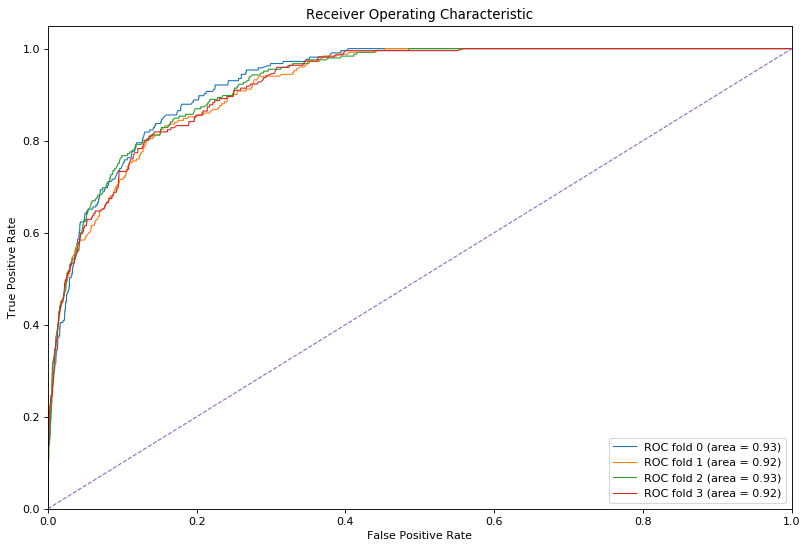

In [14]:
cv_plot_roc(k, forest4)

## Default RandomForest

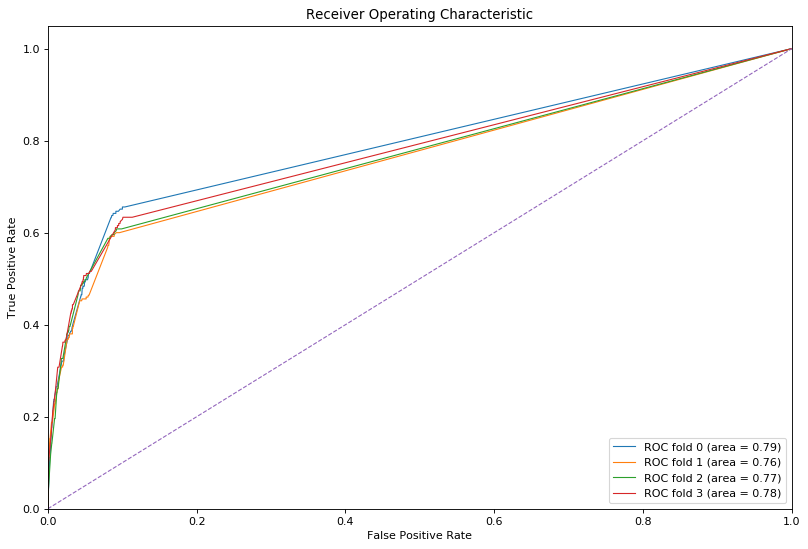

In [15]:
# Default hyperparameter
forest = RandomForestClassifier()
cv_plot_roc(k, forest)